# Assignment-14-Decision Tree-Fraud Check

Use decision trees to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

Data Description :

Undergrad : person is under graduated or not\
Marital.Status : marital status of a person\
Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government \
Work Experience : Work experience of an individual person\
Urban : Whether that person belongs to urban area or not


In [1]:
#load libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# !pip install imblearn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE,SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install category_encoders
import category_encoders as ce

In [2]:
#load dataset
df = pd.read_csv('dataset/Fraud_check.csv')
df.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [3]:
#rename columns
dict = {'Marital.Status': 'Marital_Status',
        'Taxable.Income': 'Income',
        'City.Population': 'Population',
        'Work.Experience': 'Work_Exp'}
  
# call rename () method
df.rename(columns=dict, inplace=True)
df.sample(10)

,Undergrad,Marital_Status,Income,Population,Work_Exp,Urban
144,YES,Single,79453,156503,29,YES
509,NO,Married,20309,65531,27,YES
580,YES,Divorced,31721,123335,1,YES
498,YES,Single,67936,164924,24,YES
62,NO,Divorced,91684,147684,13,YES
244,YES,Single,68268,154647,27,NO
207,YES,Married,12083,138108,28,NO
558,NO,Divorced,85570,191139,12,YES
484,YES,Married,59440,114646,28,YES
349,YES,Divorced,15491,72255,30,YES


In [4]:
#Shift Income Column at first
first_col = df.pop('Income')
df.insert(0, 'Income', first_col)
df.head()

,Income,Undergrad,Marital_Status,Population,Work_Exp,Urban
0,68833,NO,Single,50047,10,YES
1,33700,YES,Divorced,134075,18,YES
2,36925,NO,Married,160205,30,YES
3,50190,YES,Single,193264,15,YES
4,81002,NO,Married,27533,28,NO


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,600.0,55208.375000,26204.827597,10003.0,32871.50,55074.5,78611.75,99619.0
Population,600.0,108747.368333,49850.075134,25779.0,66966.75,106493.5,150114.25,199778.0
Work_Exp,600.0,15.558333,8.842147,0.0,8.00,15.0,24.00,30.0


In [6]:
df[df['Income']<=30000]

,Income,Undergrad,Marital_Status,Population,Work_Exp,Urban
10,29732,NO,Single,102602,19,YES
12,11794,NO,Divorced,148033,14,YES
16,24987,YES,Divorced,34551,29,NO
19,10987,NO,Single,126953,30,YES
21,14310,YES,Divorced,29106,7,YES
...,...,...,...,...,...,...
544,29916,NO,Single,133877,21,YES
557,12810,YES,Married,157421,10,NO
567,16316,YES,Single,129912,30,NO
575,10735,NO,Divorced,95975,13,YES


In [7]:
# Convert Sales to Category
criteria = [df['Income'].between(np.min(df.Income), 30000, inclusive='both'),
            df['Income'].between(30000, np.max(df.Income),inclusive='right')]
values = ['Risky', 'Good']
df['Income'] = np.select(criteria, values, 0)

In [8]:
df

,Income,Undergrad,Marital_Status,Population,Work_Exp,Urban
0,Good,NO,Single,50047,10,YES
1,Good,YES,Divorced,134075,18,YES
2,Good,NO,Married,160205,30,YES
3,Good,YES,Single,193264,15,YES
4,Good,NO,Married,27533,28,NO
...,...,...,...,...,...,...
595,Good,YES,Divorced,39492,7,YES
596,Good,YES,Divorced,55369,2,YES
597,Good,NO,Divorced,154058,0,YES
598,Good,YES,Married,180083,17,NO


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Income          600 non-null    object
 1   Undergrad       600 non-null    object
 2   Marital_Status  600 non-null    object
 3   Population      600 non-null    int64 
 4   Work_Exp        600 non-null    int64 
 5   Urban           600 non-null    object
dtypes: int64(2), object(4)
memory usage: 28.2+ KB


In [10]:
# list cateogrical columns
categorical = [col for col in df.columns if df[col].dtype == 'object']
categorical

['Income', 'Undergrad', 'Marital_Status', 'Urban']

In [11]:
df[categorical].sample(10)

,Income,Undergrad,Marital_Status,Urban
121,Risky,YES,Married,YES
532,Good,YES,Divorced,NO
272,Good,NO,Single,YES
438,Risky,NO,Single,NO
331,Risky,YES,Married,YES
157,Good,YES,Married,NO
377,Good,YES,Single,NO
397,Good,NO,Married,YES
66,Good,YES,Married,YES
212,Good,YES,Divorced,NO


Good     476
Risky    124
Name: Income, dtype: int64
YES    312
NO     288
Name: Undergrad, dtype: int64
Single      217
Married     194
Divorced    189
Name: Marital_Status, dtype: int64
YES    302
NO     298
Name: Urban, dtype: int64


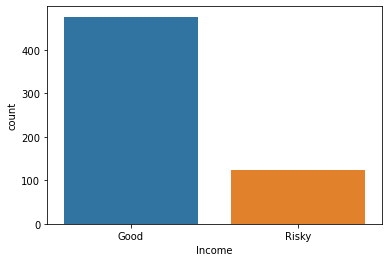

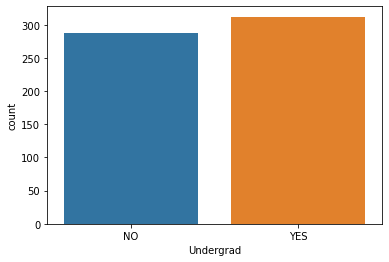

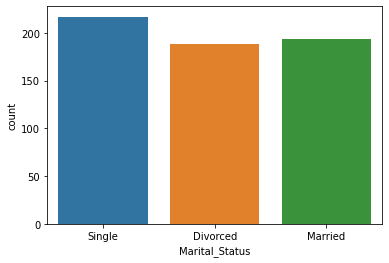

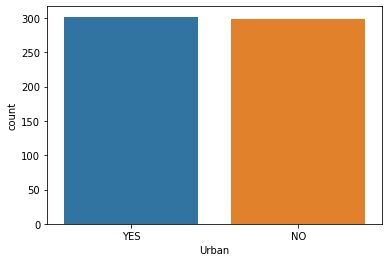

In [12]:
# frequency counts
for i, col in enumerate(categorical):
    print(df[col].value_counts())
    plt.figure(i)
    sns.countplot(x=col, data=df)

In [13]:
#check cardinality in categorical variables
for cat in categorical:
    print(cat, 'contains -', len(df[cat].unique()), 'labels')

Income contains - 2 labels
Undergrad contains - 2 labels
Marital_Status contains - 3 labels
Urban contains - 2 labels


In [14]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [15]:
#Split dataset into training and testing
x_train,x_test, y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
print("Number transactions x_train dataset: ", x_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions x_test dataset: ", x_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions x_train dataset:  (420, 5)
Number transactions y_train dataset:  (420,)
Number transactions x_test dataset:  (180, 5)
Number transactions y_test dataset:  (180,)


In [16]:
#label encoding target column
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

In [17]:
#One Hot Encoding using category_encoders for Marital_Status column
ohe = ce.BinaryEncoder(cols=['Undergrad','Marital_Status','Urban'])
x_train = ohe.fit_transform(x_train)
x_test = ohe.fit_transform(x_test)

/home/starlord/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/starlord/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [18]:
x_train_cols = x_train.columns
x_test_cols = x_test.columns

In [19]:
# Label Encoding
# def label_encode(dataset,columns):
#     for col in columns:
#         dataset[col] = LabelEncoder().fit_transform(dataset[col])
#     return dataset
# label_encode(x_train,x_train_cols)
# label_encode(x_test,x_test_cols)

In [20]:
#handling imbalanced data
print(pd.value_counts(y_train))

# sm = SMOTE(random_state=2)
# sm = BorderlineSMOTE(random_state=2)
# sm = ADASYN(random_state=2)
sm = SVMSMOTE(random_state=2)

# x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())
x_train, y_train = sm.fit_resample(x_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print(pd.value_counts(y_train))

0    333
1     87
dtype: int64
After OverSampling, the shape of train_X: (536, 9)
After OverSampling, the shape of train_y: (536,) 

0    333
1    203
dtype: int64


In [21]:
# scaling data using standard scaler
x_train = StandardScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=x_train_cols)
x_test = StandardScaler().fit_transform(x_test)
x_test = pd.DataFrame(x_test, columns=x_test_cols)

### Building Decision Tree Classifier using Entropy Criteria

In [22]:
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth=3, random_state=2)
dt.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=2)

In [23]:
def evaluate_model(dt_classifier):
    y_pred_test = dt_classifier.predict(x_test)
    y_pred_train = dt_classifier.predict(x_train)
    
    print("Train Accuracy : {0:0.4f}".format(accuracy_score(y_train, y_pred_train)))
    print("Test Accuracy : {0:0.4f}".format(accuracy_score(y_test, y_pred_test)))
    
    # getting the count of each category
    print("Count of each category:")
    print(pd.Series(y_pred_test).value_counts())
    print("-"*50)
    
    #Classification Report
    print("Classification Report:")
    print(classification_report(y_pred_test,y_test))
    print("-"*50)
    
    #Plotting confusion matrix for Decision Tree
    print("Confusion Matrix:")
    f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

    plot_0 = sns.heatmap((confusion_matrix(y_train,y_pred_train)),annot=True,fmt='.5g',cmap="GnBu",ax=a[0][0]);
    a[0][0].set_title('Training Data')

    plot_1 = sns.heatmap((confusion_matrix(y_test,y_pred_test)),annot=True,fmt='.5g',cmap="GnBu",ax=a[0][1]);
    a[0][1].set_title('Test Data');

In [24]:
def get_dt_graph(dt_classifier):
#     cn=['low','high']
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(dt_classifier,
                       feature_names=x_train.columns,
#                        class_names=cn,
                       filled=True)

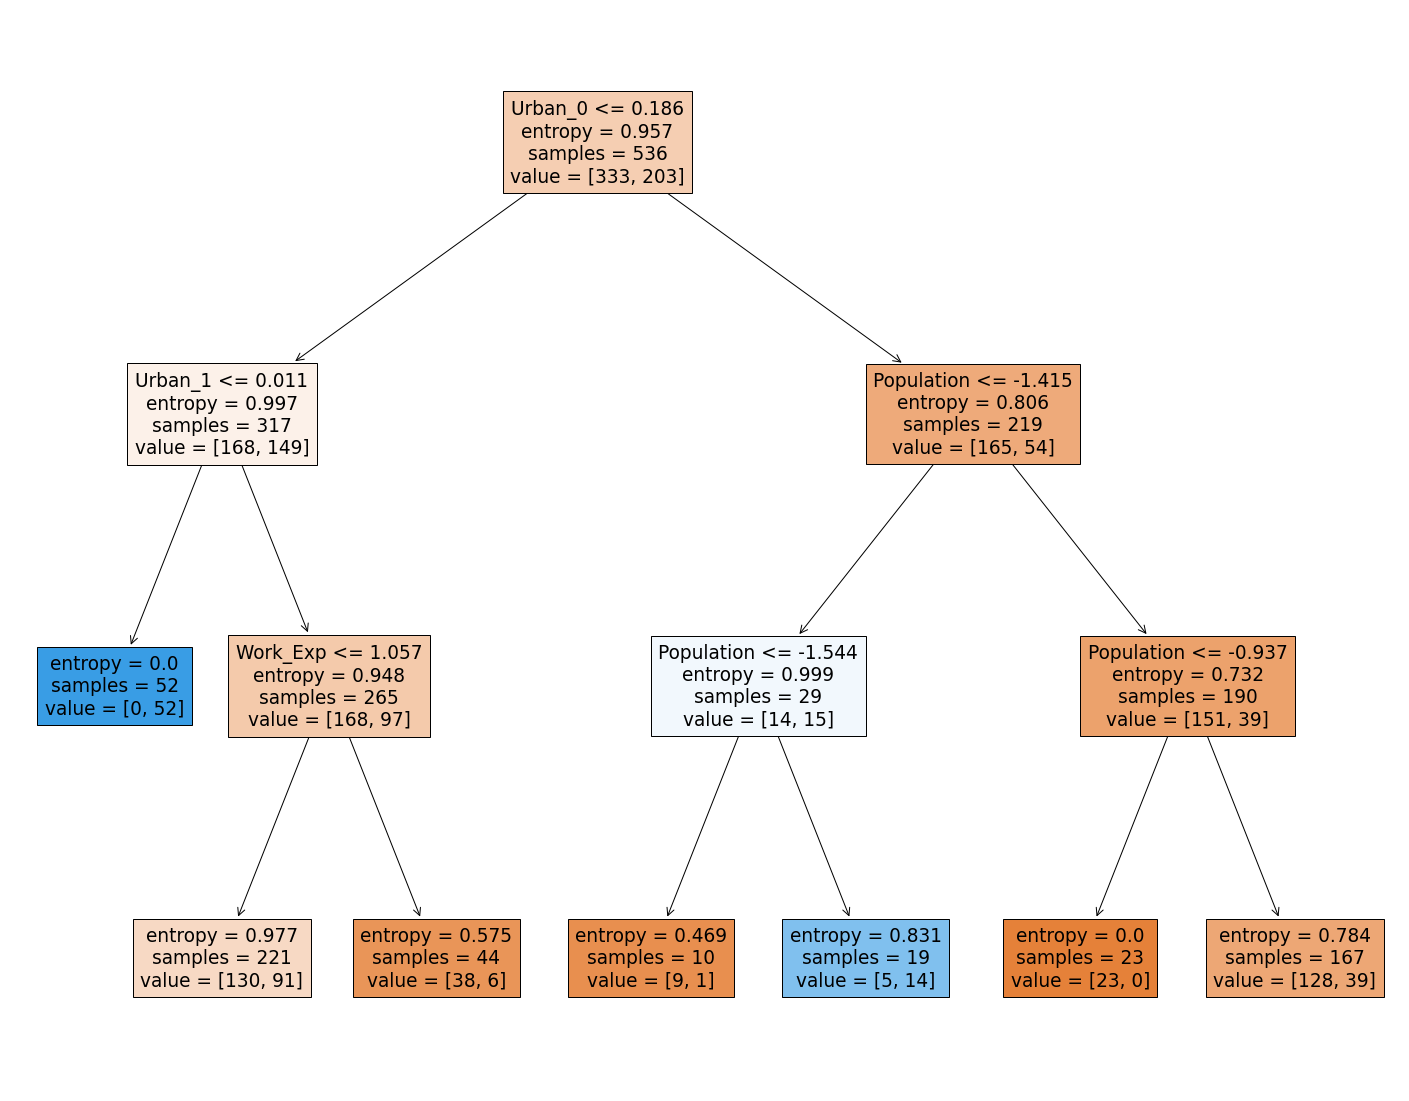

In [25]:
get_dt_graph(dt)

#### Evaluating model performance

Train Accuracy : 0.7351
Test Accuracy : 0.7778
Count of each category:
0    175
1      5
dtype: int64
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       175
           1       0.03      0.20      0.05         5

    accuracy                           0.78       180
   macro avg       0.50      0.50      0.46       180
weighted avg       0.95      0.78      0.85       180

--------------------------------------------------
Confusion Matrix:


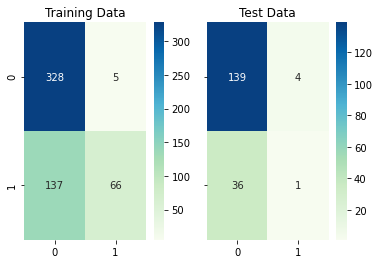

In [26]:
evaluate_model(dt)

### Building Decision Tree Classifier using Gini Index

In [27]:
gdt = DecisionTreeClassifier(criterion = 'gini',max_depth=3, random_state=2)
gdt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=3, random_state=2)

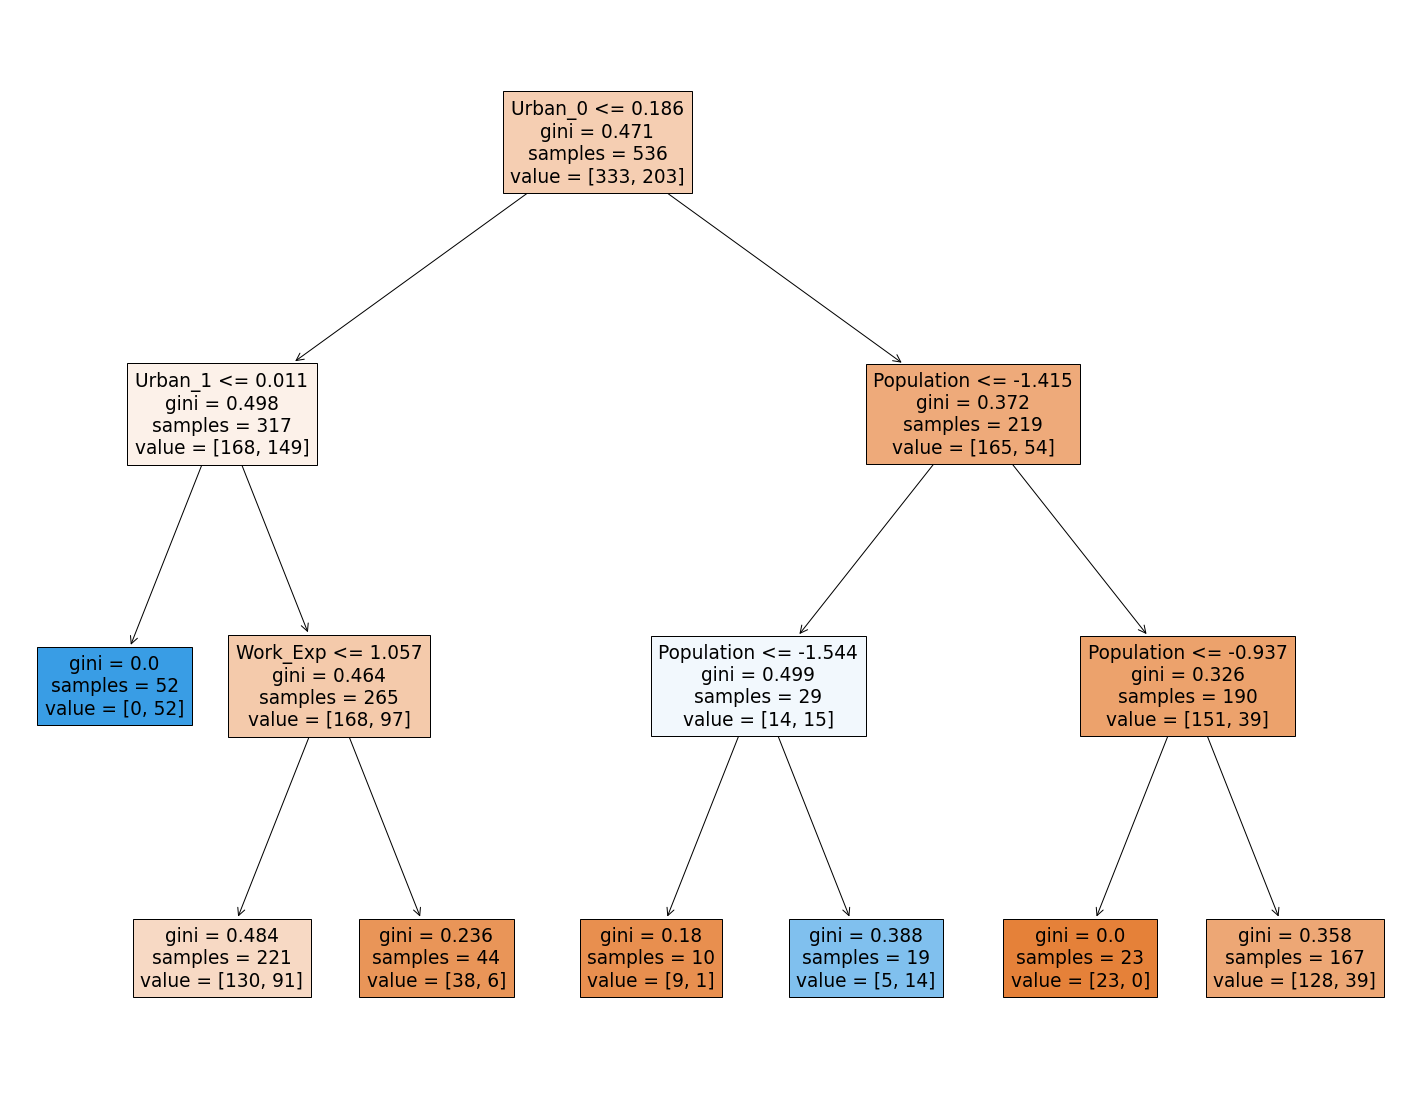

In [28]:
get_dt_graph(gdt)

#### Evaluating model performance

Train Accuracy : 0.7351
Test Accuracy : 0.7778
Count of each category:
0    175
1      5
dtype: int64
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       175
           1       0.03      0.20      0.05         5

    accuracy                           0.78       180
   macro avg       0.50      0.50      0.46       180
weighted avg       0.95      0.78      0.85       180

--------------------------------------------------
Confusion Matrix:


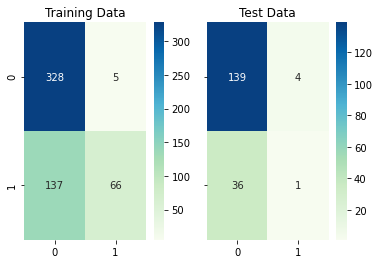

In [29]:
evaluate_model(gdt)

## Hyperparameter Tuning

In [30]:
dt = DecisionTreeClassifier(random_state=2)

In [31]:
#create paramater grid
param_grid = { 
    'max_depth':[2,3,4,5],
#     'max_depth':np.linspace(1, 32, 32, endpoint=True),
#     'ccp_alpha': np.arange(0, 1, 0.001),
    'ccp_alpha': [0.001,0.002,0.003,0.004,0.005,0.01,0.011,0.015],
    'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_splits' : np.linspace(0.1, 1.0, 10, endpoint=True),
#     'min_samples_splits' : [0.7,0.8,0.9],
    'min_samples_leaf': [2,3,5],
    'criterion':['gini','entropy']
}

In [32]:
#Instantiate Grid Search Model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, n_jobs=-1, verbose=3, scoring='accuracy')

In [33]:
%%time
grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
CPU times: user 1.42 s, sys: 132 ms, total: 1.55 s
Wall time: 8.88 s


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=2), n_jobs=-1,
             param_grid={'ccp_alpha': [0.005, 0.01, 0.011, 0.015],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 5]},
             scoring='accuracy', verbose=3)

In [34]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007156,0.003958,0.003318,0.000247,0.005,gini,2,auto,2,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.592593,0.611111,0.574074,0.622642,0.622642,0.622642,0.622642,0.600908,0.037275,241
1,0.007201,0.003222,0.005865,0.004096,0.005,gini,2,auto,3,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.592593,0.611111,0.574074,0.622642,0.622642,0.622642,0.622642,0.600908,0.037275,241
2,0.008059,0.002555,0.006118,0.004734,0.005,gini,2,auto,5,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.592593,0.611111,0.574074,0.622642,0.622642,0.622642,0.622642,0.600908,0.037275,241
3,0.007199,0.003703,0.006253,0.002212,0.005,gini,2,sqrt,2,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.592593,0.611111,0.574074,0.622642,0.622642,0.622642,0.622642,0.600908,0.037275,241
4,0.006297,0.001891,0.004942,0.001635,0.005,gini,2,sqrt,3,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.592593,0.611111,0.574074,0.622642,0.622642,0.622642,0.622642,0.600908,0.037275,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.005086,0.000320,0.003171,0.000218,0.015,entropy,5,sqrt,3,"{'ccp_alpha': 0.015, 'criterion': 'entropy', '...",...,0.537037,0.518519,0.574074,0.603774,0.660377,0.622642,0.716981,0.608526,0.056810,142
284,0.005404,0.000544,0.003244,0.000497,0.015,entropy,5,sqrt,5,"{'ccp_alpha': 0.015, 'criterion': 'entropy', '...",...,0.537037,0.518519,0.574074,0.679245,0.660377,0.622642,0.622642,0.599231,0.049439,253
285,0.005594,0.000644,0.003030,0.000277,0.015,entropy,5,log2,2,"{'ccp_alpha': 0.015, 'criterion': 'entropy', '...",...,0.537037,0.518519,0.574074,0.603774,0.660377,0.622642,0.716981,0.608526,0.056810,142
286,0.005674,0.000742,0.004017,0.001459,0.015,entropy,5,log2,3,"{'ccp_alpha': 0.015, 'criterion': 'entropy', '...",...,0.537037,0.518519,0.574074,0.603774,0.660377,0.622642,0.716981,0.608526,0.056810,142


In [35]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
28,0.005239,0.000694,0.004666,0.004845,0.005,gini,5,auto,3,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.611111,0.555556,0.592593,0.773585,0.660377,0.698113,0.735849,0.647904,0.076583,1
31,0.005309,0.001266,0.003130,0.000241,0.005,gini,5,sqrt,3,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.611111,0.555556,0.592593,0.773585,0.660377,0.698113,0.735849,0.647904,0.076583,1
34,0.005137,0.000321,0.003114,0.000175,0.005,gini,5,log2,3,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.611111,0.555556,0.592593,0.773585,0.660377,0.698113,0.735849,0.647904,0.076583,1
27,0.004890,0.000468,0.003155,0.000258,0.005,gini,5,auto,2,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.611111,0.555556,0.592593,0.773585,0.660377,0.698113,0.735849,0.646052,0.074971,4
30,0.004967,0.000458,0.003002,0.000161,0.005,gini,5,sqrt,2,"{'ccp_alpha': 0.005, 'criterion': 'gini', 'max...",...,0.611111,0.555556,0.592593,0.773585,0.660377,0.698113,0.735849,0.646052,0.074971,4


In [36]:
dt_best = grid_search.best_estimator_

In [37]:
dt_best

DecisionTreeClassifier(ccp_alpha=0.005, max_depth=5, max_features='auto',
                       min_samples_leaf=3, random_state=2)

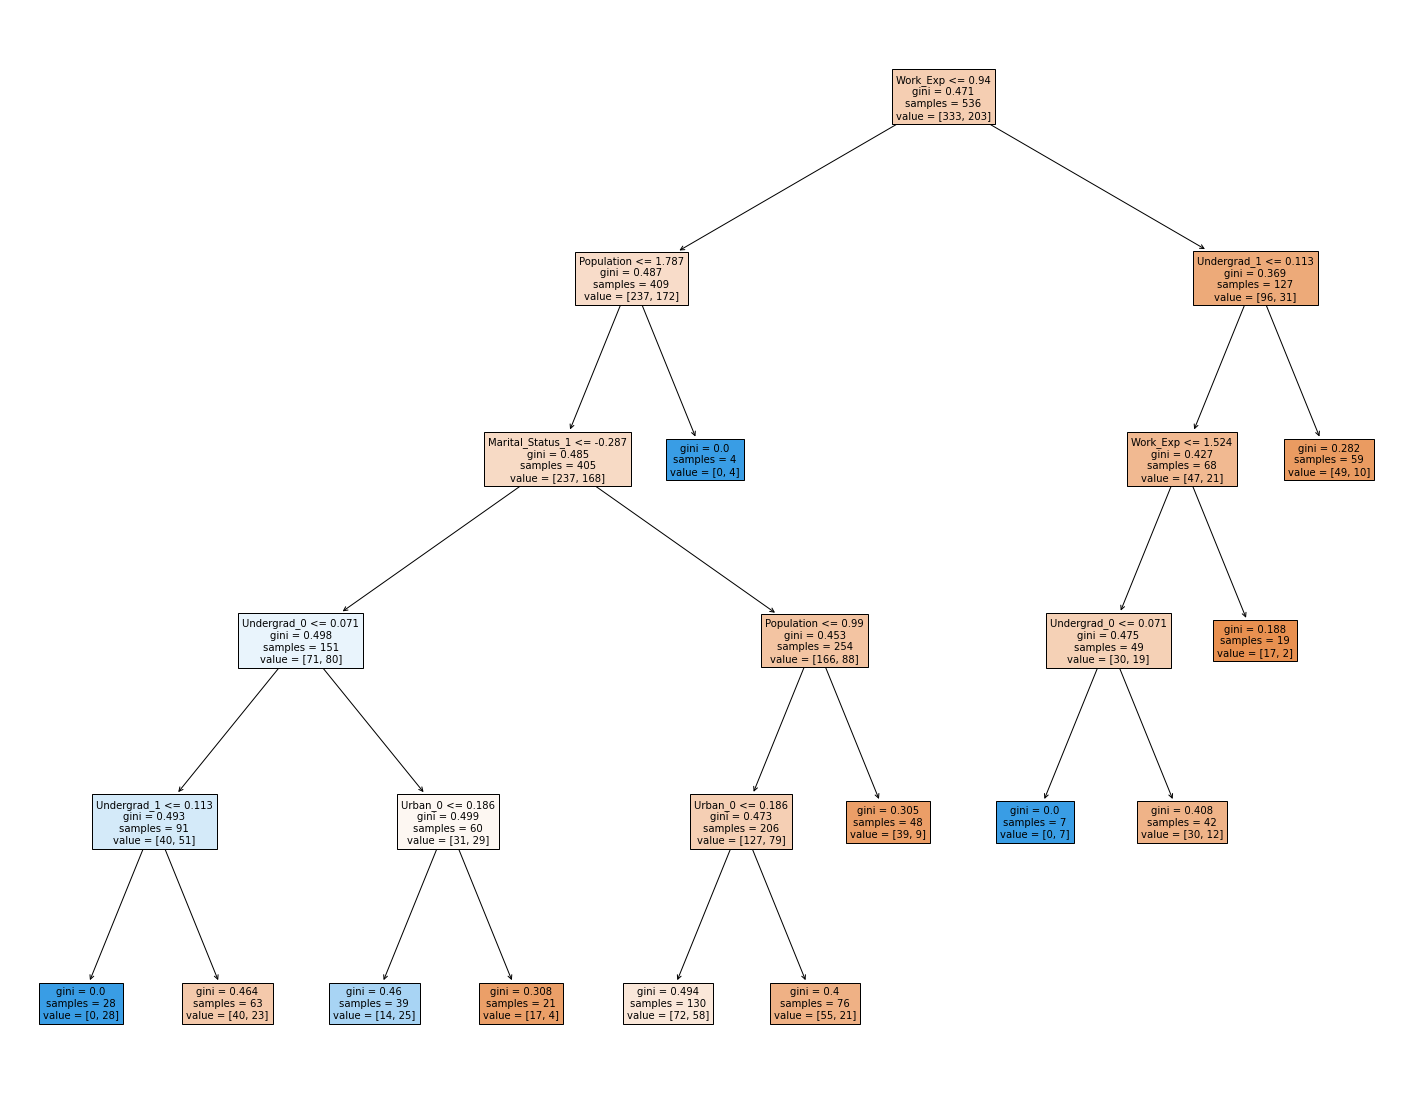

In [38]:
get_dt_graph(dt_best)

Train Accuracy : 0.7146
Test Accuracy : 0.7500
Count of each category:
0    162
1     18
dtype: int64
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       162
           1       0.14      0.28      0.18        18

    accuracy                           0.75       180
   macro avg       0.52      0.54      0.52       180
weighted avg       0.83      0.75      0.79       180

--------------------------------------------------
Confusion Matrix:


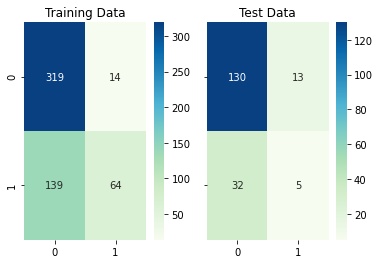

In [39]:
evaluate_model(dt_best)

In [40]:
path = dt_best.cost_complexity_pruning_path(x_train,y_train)
alphas = path['ccp_alphas']
alphas

array([0.        , 0.00015547, 0.00028429, 0.00070699, 0.00086108,
       0.00172881, 0.00384096, 0.00488654, 0.00516208, 0.00557995,
       0.00592921, 0.0103391 , 0.01163145])